# Разбираем проект по анализу данных: исследуем средний вес новорожденных

<a href="https://colab.research.google.com/github/dm-fedorov/pandas_basic/blob/master/%D0%B1%D1%8B%D1%81%D1%82%D1%80%D0%BE%D0%B5%20%D0%B2%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%B2%20pandas/01.%20%D0%9A%D0%B0%D0%BA%D0%B8%D0%B5%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5%20%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%B0%D1%82%D1%8B%D0%B2%D0%B0%D0%B5%D1%82%20pandas%3F.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory" target="_blank"></a>

*Copyright* [Allen B. Downey](https://allendowney.com)

*License:* [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

<a href="https://t.me/init_python"><img src="https://dfedorov.spb.ru/pandas/logo-telegram.png" width="35" height="35" alt="telegram" align="left"></a>

Этот пример демонстрирует важные шаги практически в любом проекте по анализу данных:

1. Определение данных, которые помогут ответить на вопрос.

2. Получение данных и их загрузка в Python.

3. Проверка данных и устранение ошибок.

4. Выбор соответствующих подмножеств из данных.

5. Использование гистограмм для визуализации распределения значений.

6. Использование сводной статистики для описания данных таким образом, чтобы наилучшим образом ответить на вопрос.

7. Рассмотрение возможных источников ошибок и ограничений в наших выводах.

Начнем с получения данных.

## Чтение данных

Мы будем использовать данные [Национального исследования роста семьи](https://www.cdc.gov/nchs/nsfg/index.htm) (*NSFG*).

> Это обследование, проведенное отделом Статистики здравоохранения Центра по контролю и профилактике заболеваний, чтобы понять тенденции, связанные с фертильностью, структурой семьи и демографией в Соединенных Штатах.

Чтобы загрузить данные, вы должны принять [Пользовательское соглашение](https://www.cdc.gov/nchs/data_access/ftp_dua.htm).
Вам следует внимательно прочитать эти условия, но позвольте обратить ваше внимание на то, что я считаю наиболее важным:

> Не пытайтесь узнать личность какого-либо лица или учреждения, включенного в эти данные.

Респонденты *NSFG* дают честные ответы на вопросы самого личного характера, ожидая, что их личности не будут раскрыты.
Как специалисты по этическим данным, мы должны уважать их конфиденциальность и соблюдать условия использования.

Респонденты *NSFG* предоставляют общую информацию о себе, которая хранится в *файле респондентов*, и информацию о каждой беременности, которая хранится в *файле о беременности*.

Мы будем работать с файлом беременности, который содержит по одной строке для каждой беременности и `248` переменных.
Каждая переменная представляет собой ответы на вопрос анкеты *NSFG*.

Данные хранятся в [формате фиксированной ширины](https://www.ibm.com/docs/en/baw/19.x?topic=formats-fixed-width-format) (*fixed-width format*), это означает, что каждая строка имеет одинаковую длину и каждая переменная охватывает фиксированный диапазон столбцов.

В дополнение к файлу данных (`2015_2017_FemPregData.dat`) нам также понадобится словарь данных (`2015_2017_FemPregSetup.dct`), который включает имена переменных и указывает диапазон столбцов, в которых появляется каждая переменная.

In [1]:
dict_file = '2015_2017_FemPregSetup.dct'
data_file = '2015_2017_FemPregData.dat'

После того, как вы согласились с условиями, вы можете использовать следующие ячейки для загрузки данных:

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [3]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/' +
         'datasets/NSFG/stata/' + dict_file)

In [4]:
download('https://ftp.cdc.gov/pub/health_statistics/nchs/' +
         'datasets/NSFG/' + data_file)

Pandas может читать данные в наиболее распространенных форматах, включая *CSV*, *Excel* и *формате фиксированной ширины*, но не может читать словарь данных, который находится в формате *Stata*.

Для этого мы будем использовать библиотеку Python под названием [`parse_stata_dict`](https://github.com/atudomain/statadict).

Следующая ячейка при необходимости устанавливает `parse_stata_dict`.

In [5]:
try:
    from statadict import parse_stata_dict
except ImportError:
    !pip install statadict

Из `parse_stata_dict` мы импортируем функцию `parse_stata_dict`, которая читает словарь данных.

In [6]:
from statadict import parse_stata_dict

stata_dict = parse_stata_dict(dict_file)
stata_dict

В результате получается объект, содержащий атрибуты

* `names`, который представляет собой список имен переменных, и

* `colspecs`, который представляет собой список кортежей.

Каждый кортеж в `colspecs` определяет первый и последний столбцы, в которых появляется переменная.

Эти значения - именно те аргументы, которые нам нужны для использования [`read_fwf`](https://pandas.pydata.org/docs/reference/api/pandas.read_fwf.html), функции Pandas, считывающей файл в *формате фиксированной ширины*.

In [7]:
import pandas as pd

nsfg = pd.read_fwf(data_file, 
                   names=stata_dict.names, 
                   colspecs=stata_dict.colspecs)
type(nsfg)

pandas.core.frame.DataFrame

Результатом вызова `read_hdf()` стал `DataFrame`, который является основным типом Pandas для хранения данных.

В `DataFrame` есть метод `head()`, который показывает первые `5` строк:

In [8]:
nsfg.head()

,CASEID,PREGORDR,HOWPREG_N,HOWPREG_P,MOSCURRP,NOWPRGDK,PREGEND1,PREGEND2,HOWENDDK,NBRNALIV,...,SECU,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR
0,70627,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
1,70627,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,3,322,1394,1382,1357,1345,1333,18,1,2016
2,70627,3,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,3,322,1394,1382,1357,1345,1333,18,1,2016
3,70628,1,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017
4,70628,2,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1.0,...,2,366,1409,1397,1369,1357,1345,23,1,2017


Первый столбец - это `CASEID`, который представляет собой уникальный идентификатор для каждого респондента.

Первые три строки содержат один и тот же `CASEID`, поэтому респондентка сообщила информацию о трех беременностях.

Второй столбец - это `PREGORDR`, который указывает порядок беременностей для каждой респондентки, начиная с `1`.

Мы узнаем больше о других переменных по мере исследования.

В дополнение к таким методам, как `head`, `nsfg` имеет несколько **атрибутов**, которые представляют собой переменные, связанные с определенным типом. 

Например, у `nsfg` есть атрибут под названием `shape`, который представляет собой количество строк и столбцов:

In [9]:
nsfg.shape

(9553, 248)

В этом наборе данных `9553` строки, по одной для каждой беременности, и `248` столбцов, по одной для каждой переменной.

`nsfg` также имеет атрибут под названием `columns`, который содержит имена столбцов:

In [10]:
nsfg.columns

Index(['CASEID', 'PREGORDR', 'HOWPREG_N', 'HOWPREG_P', 'MOSCURRP', 'NOWPRGDK',
       'PREGEND1', 'PREGEND2', 'HOWENDDK', 'NBRNALIV',
       ...
       'SECU', 'SEST', 'CMINTVW', 'CMLSTYR', 'CMJAN3YR', 'CMJAN4YR',
       'CMJAN5YR', 'QUARTER', 'PHASE', 'INTVWYEAR'],
      dtype='object', length=248)

Имена столбцов хранятся в `Index`, который является типом Pandas, похожим на список.

In [11]:
type(nsfg.columns)

pandas.core.indexes.base.Index

Основываясь на именах столбцов, вы можете догадаться, что это за переменные, но в целом вам необходимо прочитать документацию.

Когда вы работаете с наборами данных, такими как *NSFG*, важно внимательно читать документацию. Если вы интерпретируете переменную неправильно, вы можете получить бессмысленные результаты и никогда этого не осознать. Итак, прежде чем мы начнем рассматривать данные, давайте познакомимся с кодовой книгой *NSFG*, которая описывает каждую переменную.

До недавнего времени кодовая книга *NSFG* была доступна в интерактивном онлайн-формате.
К сожалению, она больше не доступна, поэтому необходимо использовать [этот PDF-файл](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/data/2015-2017_NSFG_FemPregFile_Codebook-508.pdf), который содержит краткое описание каждой переменной.

Если вы выполните поиск в этом документе по запросу *"weigh at birth"*, вы должны найти эти переменные, связанные с массой тела при рождении.

* `BIRTHWGT_LB1`: масса тела при рождении в фунтах (*Pounds*) - первый ребенок от этой беременности.

* `BIRTHWGT_OZ1`: вес при рождении в унциях (*Ounces*) - первый ребенок от этой беременности.

Подобные переменные существуют для 2-го или 3-го ребенка, в случае двойни или тройни.
Сейчас мы сосредоточимся на первом ребенке от каждой беременности и вернемся к вопросу о многоплодных родах.

## Series

Во многих отношениях `DataFrame` похож на словарь Python, где имена столбцов являются ключами, а столбцы - значениями. Вы можете выбрать столбец из `DataFrame` с помощью оператора скобок со строкой в качестве ключа.

In [12]:
pounds = nsfg['BIRTHWGT_LB1']
type(pounds)

pandas.core.series.Series

Результатом будет `Series`, который является еще одним типом данных Pandas.
В этом случае `Series` содержат массу тела в фунтах для каждого рожденного.

`head` показывает первые пять значений в серии, имя серии и тип данных:

In [13]:
pounds.head()

0    7.0
1    NaN
2    9.0
3    6.0
4    7.0
Name: BIRTHWGT_LB1, dtype: float64

Одно из значений - `NaN`, что означает *"Not a Number"*. 

`NaN` - это специальное значение, используемое для обозначения недопустимых или отсутствующих данных. В этом примере беременность не закончилась рождением, поэтому вес при рождении неприменим.

**Упражнение:** Переменная `BIRTHWGT_OZ1` содержит часть веса при рождении в унциях.

Выберите столбец `'BIRTHWGT_OZ1'` из фрейма данных `nsfg` и присвойте его новой переменной с именем `ounces`. Затем отобразите первые пять элементов `ounces`.

In [14]:
# Решение идет здесь

**Упражнение:** Вы можете найти документацию по типам данных Pandas по адресам:

* [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

* [Index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.html)

* [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)

Эта документация может быть огромной; Не рекомендую пытаться читать все это сейчас. Но вы можете просмотреть, чтобы знать, где искать позже.

## Проверка

На этом этапе мы определили столбцы, которые нам нужны для ответа на вопрос, и присвоили их переменным с именами `pounds` и `ounces`.

In [15]:
pounds = nsfg['BIRTHWGT_LB1']
ounces = nsfg['BIRTHWGT_OZ1']

Прежде чем что-либо делать с этими данными, мы должны их проверить (*validate*). Одна часть проверки - это подтверждение того, что мы правильно интерпретируем данные.

Мы можем использовать метод `value_counts`, чтобы увидеть, какие значения появляются в `pounds` и сколько раз появляется каждое значение.

In [16]:
pounds.value_counts()

7.0     2268
6.0     1644
8.0     1287
5.0      570
9.0      396
4.0      179
99.0      89
10.0      82
3.0       76
2.0       46
1.0       28
11.0      17
98.0       2
12.0       2
0.0        2
14.0       1
13.0       1
Name: BIRTHWGT_LB1, dtype: int64

По умолчанию результаты сортируются сначала по наиболее частому значению, но вместо этого мы можем использовать `sort_index`, чтобы отсортировать их:

In [17]:
pounds.value_counts().sort_index()

0.0        2
1.0       28
2.0       46
3.0       76
4.0      179
5.0      570
6.0     1644
7.0     2268
8.0     1287
9.0      396
10.0      82
11.0      17
12.0       2
13.0       1
14.0       1
98.0       2
99.0      89
Name: BIRTHWGT_LB1, dtype: int64

Как и следовало ожидать, наиболее частыми значениями являются `6-8` фунтов, но есть несколько очень легких детей, несколько очень тяжелых детей и два специальных значения, `98` и `99`. Согласно кодовой книге, эти значения указывают на то, что респондент отказался отвечать на вопрос (`98`) или не знал (`99`).

Мы можем проверить результаты, сравнив их с кодовой книгой, в которой перечислены значения и их частота.

| Значение | Метка | Итого |
| ------- | ---------------- | ------- |
| . | НЕПРИМЕНИМО (INAPPLICABLE) | 2863 |
| 0-5 | ДО 6 ФУНТОВ | 901 |
| 6 | 6 ФУНТОВ | 1644 |
| 7 | 7 ФУНТОВ | 2268 |
| 8 | 8 ФУНТОВ | 1287 |
| 9-95 | 9 ФУНТОВ ИЛИ БОЛЬШЕ | 499 |
| 98 | Отказано (Refused) | 2 |
| 99 | Не знаю | 89 |
| | Итого | 9553 |

Результаты от `value_counts` согласуются с кодовой книгой, поэтому у нас есть некоторая уверенность в том, что мы читаем и интерпретируем данные правильно.

**Упражнение:** В фрейме данных `nsfg` столбец `'OUTCOME'` кодирует исход каждой беременности, как показано ниже:

| Значение | Смысл |
| --- | --- |
| 1 | Рождение (Live birth) |
| 2 | Искусственный аборт (Induced abortion) |
| 3 | Мертворождение (Stillbirth) |
| 4 | Выкидыш (Miscarriage) |
| 5 | Внематочная беременность (Ectopic pregnancy) |
| 6 | Текущая беременность (Current pregnancy) |

Используйте `value_counts`, чтобы отобразить значения в этом столбце и сколько раз появляется каждое значение. Соответствуют ли результаты [кодовой книге](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/data/2015-2017_NSFG_FemPregFile_Codebook-508.pdf)?

In [18]:
# Решение идет здесь

## Сводные статистические данные

Другой способ проверить данные - это `describe`, который вычисляет сводную статистику, такую как *среднее значение*, *стандартное отклонение*, *минимум* и *максимум*.

Вот результаты для `pounds`.

In [19]:
pounds.describe()

count    6690.000000
mean        8.008819
std        10.771360
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        99.000000
Name: BIRTHWGT_LB1, dtype: float64

`count` - это количество значений, не считая `NaN`. Для этой переменной есть `6690` значений, отличных от `NaN`.

`mean` и `std` - это *среднее значение* и *стандартное отклонение*.

`min` и `max` - это минимальное и максимальное значения, а между ними - `25`, `50` и `75` процентили. `50`-й процентиль - это *медиана*.

Среднее значение составляет около `8.05`, но это мало что значит, потому что оно включает специальные значения `98` и `99`. Прежде чем мы действительно сможем вычислить среднее значение, мы *должны заменить эти значения* на `NaN`, чтобы идентифицировать их как отсутствующие данные.

Метод `replace()` делает то, что мы хотим:

In [20]:
import numpy as np

pounds_clean = pounds.replace([98, 99], np.nan)

`replace` принимает список значений, которые мы хотим заменить, и значение, которым мы хотим их заменить. 

`np.nan` означает, что мы получаем специальное значение `NaN` из библиотеки NumPy, которая импортируется как `np`.

Результатом `replace()` является новая серия, которую я присваиваю переменной `pounds_clean`.

Если мы снова запустим `describe`, мы увидим, что `count` включает только допустимые значения.

In [21]:
pounds_clean.describe()

count    6599.000000
mean        6.754357
std         1.383268
min         0.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        14.000000
Name: BIRTHWGT_LB1, dtype: float64

Средний вес новой серии составляет около `6,7` фунтов.
Помните, что среднее значение оригинальной серии было более `8` фунтов.
Это имеет большое значение, когда вы убираете несколько `99`-фунтовых младенцев!

**Упражнение:** Используйте `describe`, чтобы суммировать `ounces`.

Затем используйте `replace`, чтобы заменить специальные значения `98` и `99` на `NaN`, и присвойте результат переменной `ounces_clean`.

Снова запустите `describe`. Насколько эта очистка влияет на результат?

In [22]:
# Решение идет здесь

In [23]:
# Решение идет здесь

In [24]:
# Решение идет здесь

## Арифметика с сериями

Теперь мы хотим объединить `pounds` и `ounces` в одну серию, содержащую общий вес при рождении.
Арифметические операторы работают с объектами `Series`; так, например, чтобы преобразовать `pounds` в унции, мы могли бы написать

`pounds * 16`

Затем мы могли бы добавить `ounces` вот так

`pounds * 16 + ounces`


**Упражнение:** Используйте `pounds_clean` и `ounces_clean`, чтобы вычислить общий вес при рождении, выраженный в килограммах (это примерно `2,2` фунта на килограмм). Какой средний вес при рождении в килограммах?

In [25]:
# Решение идет здесь

**Упражнение:** Для каждой беременности в наборе данных *NSFG* переменная `'AGECON'` кодирует возраст респондента на момент зачатия, а `'AGEPREG'` - возраст респондента в конце беременности.

Обе переменные записываются как целые числа с двумя неявными десятичными знаками, поэтому значение `2575` означает, что возраст респондента был `25.75`.

- Прочтите документацию по этим переменным. Есть ли какие-то особые значения, с которыми нам приходится иметь дело?

- Выберите `'AGECON'` и `'AGEPREG'`, разделите их на `100` и присвойте их переменным с именами `agecon` и `agepreg`.

- Вычислите разницу, которая является оценкой продолжительности беременности.

- Используйте `.describe()` для вычисления средней продолжительности и другой сводной статистики.

Если средняя продолжительность беременности кажется короткой, помните, что этот набор данных включает все беременности, а не только те, которые закончились рождением.

In [26]:
# Решение идет здесь

## Гистограммы

Вернемся к первоначальному вопросу: каков средний вес новорожденных в США?
В качестве ответа мы *могли бы* взять результаты из предыдущего раздела и вычислить среднее значение:

In [27]:
pounds_clean = pounds.replace([98, 99], np.nan)
ounces_clean = ounces.replace([98, 99], np.nan)

birth_weight = pounds_clean + ounces_clean / 16
birth_weight.mean()

7.180217889908257

Но вычислять сводную статистику, например среднее значение, до того, как мы рассмотрим все распределение значений, рискованно.

**Распределение** - это набор возможных значений и их частот. Одним из способов визуализации распределения является *гистограмма*, которая показывает значения по оси `x` и их частоты по оси `y`.

`Series` предоставляет метод `hist`, который строит гистограммы. И мы можем использовать `Matplotlib` для маркировки осей.

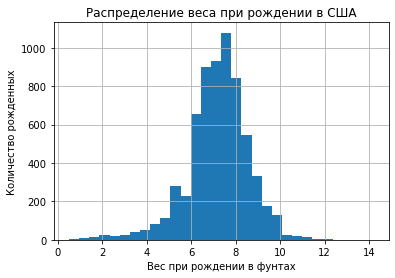

In [28]:
import matplotlib.pyplot as plt

birth_weight.hist(bins=30)
plt.xlabel('Вес при рождении в фунтах')
plt.ylabel('Количество рожденных')
plt.title('Распределение веса при рождении в США');

Ключевой аргумент `bins`, указывает `hist` разделить диапазон весов на `30` интервалов, называемых **bins**, и подсчитать, сколько значений попадает в каждую ячейку.

По оси `x` отложена масса тела при рождении в фунтах; ось `y` - это количество рождений в каждой ячейке (*bin*).

Распределение немного похоже на колоколообразную кривую, но хвост слева длиннее, чем справа; то есть легких младенцев больше, чем тяжелых.

В этом есть смысл, потому что в распределение включены некоторые недоношенные дети.

**Упражнение:** `hist` принимает ключевые аргументы, которые определяют тип и внешний вид гистограммы.

[Найдите документацию](https://pandas.pydata.org/docs/reference/api/pandas.Series.hist.html) по `hist` и посмотрите, сможете ли вы выяснить, как построить гистограмму в виде [незаполненной линии](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) (unfilled line).

In [29]:
# Решение идет здесь

**Упражнение:** Как мы видели в предыдущем упражнении, набор данных *NSFG* включает столбец под названием `AGECON`, в котором записывается возраст на момент зачатия для каждой беременности.

- Выберите этот столбец в `DataFrame` и разделите на `100`, чтобы преобразовать его в годы.

- Постройте гистограмму этих значений с `20` ячейками (*bins*).

- Обозначьте оси `x` и `y` соответствующим образом.

In [30]:
# Решение идет здесь

## Логическая серия (boolean series)

Мы видели, что распределение веса при рождении **смещено** влево; то есть легких младенцев больше, чем тяжелых, и они дальше от средних. Это потому, что недоношенные дети, как правило, легче. 

Наиболее частая продолжительность беременности составляет `39 недель`, что является "доношенной"; "недоношенность" обычно определяется как срок менее `37 недель`.

Чтобы узнать, какие дети недоношены, мы можем использовать `PRGLNGTH`, который содержит продолжительность беременности в неделях и вычисляет ее как `37`.

In [31]:
preterm = (nsfg['PRGLNGTH'] < 37)
preterm.dtype

dtype('bool')

Когда вы сравниваете `Series` со значением, результатом является логическая серия; то есть каждый элемент является логическим значением `True` или `False`. В этом случае для каждого недоношенного ребенка - это `True`, в противном случае - `False`. Мы можем использовать `head`, чтобы увидеть первые `5` элементов.

In [32]:
preterm.head()

0    False
1     True
2    False
3    False
4    False
Name: PRGLNGTH, dtype: bool

Если вы вычисляете сумму логической серии, она обрабатывает `True` как `1` и `False` как `0`, поэтому сумма представляет собой количество значений `True`, то есть количество недоношенных детей, около `3700`.

In [33]:
preterm.sum()

3675

Если вы вычисляете среднее значение логической серии, вы получаете *долю* (*fraction*) от значений `True`.
В данном случае это около `0,38`; то есть около `38%` беременностей длится менее `37 недель`.

In [34]:
preterm.mean()

0.38469590704490736

Однако этот результат может вводить в заблуждение, поскольку он включает все исходы беременности, а не только рождения.
Мы можем создать еще одну логическую серию, чтобы указать, какие беременности закончились рождением:

In [35]:
live = (nsfg['OUTCOME'] == 1)
live.mean()

0.7006176070344394

Теперь мы можем использовать логический оператор `&` для определения беременностей, результатом которых являются преждевременные роды:

In [36]:
live_preterm = (live & preterm)
live_preterm.mean()

0.08929132209777034

**Упражнение:** Какая часть всех рождений является недоношенными?

In [37]:
# Решение идет здесь

Другие распространенные логические операторы:
    
* `|`, который является оператором ИЛИ; например `live | preterm` - истина, если либо `live` - истина, либо `preterm` - истина, либо и то, и другое.

* `~`, который является оператором НЕ; например, `~live` истинно, если `live` ложно или `NaN`.

Логические операторы обрабатывают `NaN` так же, как `False`. Таким образом, вы должны быть осторожны при использовании оператора НЕ с серией, содержащей значения `NaN`.

Например, `~preterm` будут включать не только доношенные беременности, но и беременности с неизвестной продолжительностью.

**Упражнение:** Какая доля всех беременностей является доношенной, то есть `37` недель или более? Какая доля всех рожденных является доношенными?

In [38]:
# Решение идет здесь

In [39]:
# Решение идет здесь

## Фильтрация

Мы можем использовать логическую серию в качестве фильтра; то есть мы можем выбрать только те строки, которые удовлетворяют условию или удовлетворяют некоторому критерию.

Например, мы можем использовать `preterm` и оператор скобки для выбора значений из `birth_weight`, так что `preterm_weight` получает вес при рождении для недоношенных детей.

In [40]:
preterm_weight = birth_weight[preterm]
preterm_weight.mean()

5.480958781362007

Чтобы выбрать доношенных детей, мы можем создать логическую серию следующим образом:

In [41]:
fullterm = (nsfg['PRGLNGTH'] >= 37)

Для выбора веса при рождении доношенных детей используйте:

In [42]:
full_term_weight = birth_weight[fullterm]
full_term_weight.mean()

7.429609416096791

Как и ожидалось, доношенные дети в среднем тяжелее недоношенных.
Чтобы быть более точным, мы также можем ограничить результаты рождением, например:

In [43]:
full_term_weight = birth_weight[live & fullterm]
full_term_weight.mean()

7.429609416096791

Но в этом случае мы получаем тот же результат, потому что `birth_weight` действителен только для рожденных.

**Упражнение:** Давайте посмотрим, есть ли разница в весе между одноплодными и многоплодными родами (двойняшки, тройни и т. д.).

Переменная `NBRNALIV` представляет количество детей, рожденных живыми от одной беременности.

In [44]:
nbrnaliv = nsfg['NBRNALIV']
nbrnaliv.value_counts()

1.0    6573
2.0     111
3.0       6
Name: NBRNALIV, dtype: int64

Используйте `nbrnaliv` и `live`, чтобы создать логический ряд под названием `multiple`, который является верным для множественных рождений. 

Какая доля всех рождений приходится на многоплодие?

In [45]:
# Решение идет здесь

In [46]:
# Решение идет здесь

**Упражнение:** Создайте логический ряд под названием `single`, который подходит для одноплодных рождений. 

Какая часть всех одноплодных родов является преждевременными? 

Какая часть всех родов являются преждевременными?

In [47]:
# Решение идет здесь

In [48]:
# Решение идет здесь

In [49]:
# Решение идет здесь

**Упражнение:** Каков средний вес при рождении живыми (*live*), одноплодными (*single*) и доношенными (*full-term births*)?

In [50]:
# Решение идет здесь

## Средневзвешенное значение

Мы почти готовы вычислить средний вес при рождении, но нам нужно решить еще одну проблему: *передискретизацию* (*oversampling*).

*NSFG* не совсем репрезентативен для населения США. По замыслу, некоторые группы чаще появляются в выборке, чем другие; то есть они **передискретизированы** (*oversampled*). Передискретизация помогает гарантировать, что у вас будет достаточно людей в каждой подгруппе для получения надежной статистики, но это немного усложняет анализ данных.

Каждая беременность в наборе данных имеет **вес выборки** (*sampling weight*), который указывает, сколько беременностей она представляет. В `nsfg` вес выборки хранится в столбце с именем `wgt2015_2017`. Вот как это выглядит.

In [51]:
sampling_weight = nsfg['WGT2015_2017']
sampling_weight.describe()

count      9553.000000
mean      13337.425944
std       16138.878271
min        1924.916000
25%        4575.221221
50%        7292.490835
75%       15724.902673
max      106774.400000
Name: WGT2015_2017, dtype: float64

Среднее значение (`50`-й процентиль) в этом столбце составляет около `7292`, что означает, что беременность с таким весом представляет собой `7292` беременностей в популяции.

Но диапазон значений широк, поэтому некоторые строки представляют намного больше беременностей, чем другие.

Чтобы учесть эти веса, мы можем вычислить **среднее арифметическое взвешенное** (*weighted mean*). 

Вот шаги:

1. Умножьте вес при рождении для каждой беременности на веса выборки и сложите произведения.

2. Сложите выборочные веса.

3. Разделите первую сумму на вторую.

Чтобы сделать это правильно, мы должны быть осторожны с пропущенными (*missing*) данными.
Чтобы помочь с этим, мы будем использовать два метода `Series`: `isna` и `notna`.

`isna` возвращает логическое значение `Series`, равное `True`, где соответствующее значение - `NaN`.

In [52]:
missing = birth_weight.isna()
missing.sum()

3013

В `birth_weight` `3013` пропущенных значений (в основном для беременностей, которые не закончились рождением).

`notna` возвращает логическое значение `Series`, которое имеет значение `True`, где соответствующее значение *не* `NaN`.

In [53]:
valid = birth_weight.notna()
valid.sum()

6540

Мы можем комбинировать `valid` с другими вычисленными нами логическими `Series`, чтобы идентифицировать одноплодные (*single*), доношенные рождения с допустимым весом при рождении.

In [54]:
single = (nbrnaliv == 1)
selected = valid & live & single & fullterm
selected.sum()

5648

**Упражнение:** Используйте `selected`, `birth_weight` и `sampling_weight`, чтобы вычислить средневзвешенное значение веса при рождении для живых (*live*), одноплодных (*single*) и доношенных детей (*full term*).

Вы должны обнаружить, что взвешенное среднее немного больше невзвешенного среднего, которое мы вычислили в предыдущем разделе. Это связано с тем, что группы, для которых в *NSFG* представлена избыточная выборка (*oversampled*), как правило, в среднем рожают более легких детей.

In [55]:
# Решение идет здесь

In [56]:
# Решение идет здесь

## Резюме

В этом Блокноте задается, казалось бы, простой вопрос: каков средний вес новорожденных в Соединенных Штатах?

Чтобы ответить на него, мы нашли подходящий набор данных и прочитали файлы. Затем мы проверили данные и обработали специальные значения, отсутствующие данные и ошибки.

Чтобы исследовать данные, мы использовали `value_counts`, `hist`, `describe` и другие методы Pandas.
А для выбора релевантных данных мы использовали логическое значение `Series`.

Попутно нам пришлось больше думать над этим вопросом. Что мы подразумеваем под "средним" и каких младенцев мы должны включать? Должны ли мы включать всех родившихся или исключать недоношенных или многоплодных детей?

И нам нужно было подумать о процессе *семплирования* (*sampling process*). По замыслу респонденты *NSFG* не являются репрезентативными для населения США, но мы можем использовать *веса выборки*, чтобы скорректировать этот эффект.

Даже простой вопрос может стать сложным проектом в области науки о данных.

<a href="https://t.me/init_python"><img src="https://dfedorov.spb.ru/pandas/logo-telegram.png" width="35" height="35" alt="telegram" align="left"></a>